In [1]:
#!/usr/bin/python

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# import os
# import sys
import numpy as np

import time

from reservoir import Reservoir
import data

%load_ext autoreload
%autoreload 1
%aimport data
%aimport reservoir

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
roll_num = 100
spatial_points = 50
enc_depth = 8
n_res = 4000
b = Reservoir(n_res=n_res, input_scale=2, train_method='ridge', train_param=2000,
              weights_type='complex gaussian', random_projection='simulation',
              activation_fun='binary', activation_param=1,encoding_method='naivebinary', 
              encoding_param=0.55, input_dim=(2**enc_depth)*spatial_points, forget=100)

In [3]:
ks_data, xx, tt = data.kuramoto_sivashinsky(sequence_length=2000, n_sequence=5, spatial_points=spatial_points)
y = data.roll_and_concat(ks_data, roll_num=roll_num)
b.fit(ks_data, y)

Start of training...
Initialization finished. Elapsed time:
8.857597589492798
100%|██████████| 2001/2001 [01:40<00:00, 20.00it/s]
(5, 1901, 16800)
Iterations finished. Elapsed time:
497.10458302497864
Training finished. Elapsed time:
566.8853371143341
Training score:
0.8244844486006393


Reservoir(activation_fun='binary', activation_param=1,
     encoding_method='naivebinary', encoding_param=0.55, forget=100,
     input_dim=12800, input_scale=2, n_res=4000, opu_transform=None,
     random_projection='simulation',
     random_state=<mtrand.RandomState object at 0x7f9e6805da68>,
     res_scale=1, save=0, train_method='ridge', train_param=2000,
     verbose=1, weights_type='complex gaussian')

In [4]:
ks_data, xx, tt = data.kuramoto_sivashinsky(sequence_length=2000, n_sequence=1, spatial_points=spatial_points)
y = data.roll_and_concat(ks_data, roll_num=roll_num)[:, b.forget:, :]
y_target = y.reshape(-1, y.shape[-1])
pred_output, valid_score = b.score(ks_data, y_target)

Start of testing...
Initialization finished. Elapsed time:
0.4809441566467285
100%|██████████| 2001/2001 [01:38<00:00, 20.36it/s]
(1, 1901, 16800)
Iterations finished. Elapsed time:
98.79261231422424
Testing finished. Elapsed time:
108.24297165870667
Testing finished. Elapsed time:
566.8853371143341
Testing score:
0.3612524030344856


In [26]:
axarr[0,0]

<function matplotlib.pyplot.show(*args, **kw)>

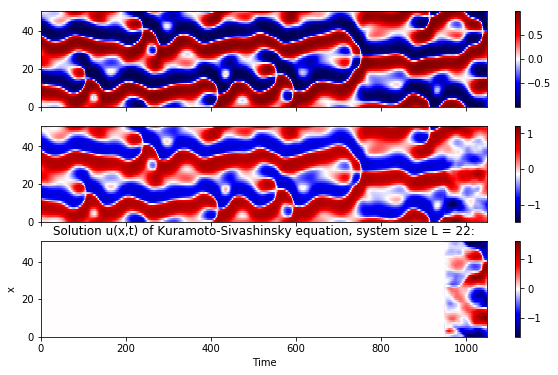

In [37]:
n_input = round(pred_output.shape[0]/2)
prediction = np.zeros((roll_num, spatial_points + 1))
for i in range(roll_num):
    prediction[i, :] = pred_output[n_input, i*(spatial_points+1):(i+1)*(spatial_points + 1)]
all_data = np.concatenate((y_target[0:n_input, 0:spatial_points+1], prediction))

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10,6))
plt.title('Solution u(x,t) of Kuramoto-Sivashinsky equation, system size L = 22:')
plt.ylabel('x')
plt.xlabel('Time')
im=axs[0].pcolormesh(y_target[0:n_input+roll_num, 0:spatial_points+1].T, cmap='seismic')
plt.colorbar(im, ax=axs[0])

im=axs[1].pcolormesh(all_data.T, cmap='seismic')
plt.colorbar(im, ax=axs[1])

im=axs[2].pcolormesh(y_target[0:n_input+roll_num, 0:spatial_points+1].T-all_data.T, cmap='seismic')
plt.colorbar(im, ax=axs[2])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

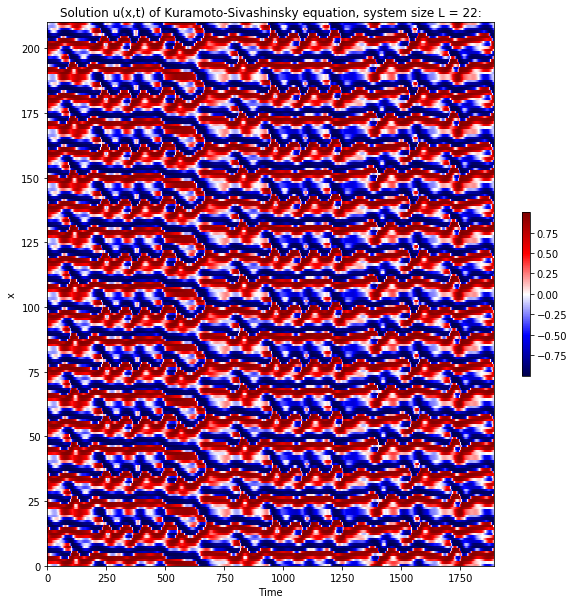

In [8]:
plt.figure(figsize=(10,10))
plt.title('Solution u(x,t) of Kuramoto-Sivashinsky equation, system size L = 22:')
plt.ylabel('x')
plt.xlabel('Time')
im=plt.pcolormesh(y_target.T[:,:-roll_num], cmap='seismic') # tt[:, b.forget:], xx
plt.colorbar(im, shrink=0.3)
# plt.axes().set_aspect(.5) # 4*spatial_points/sequence_length
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

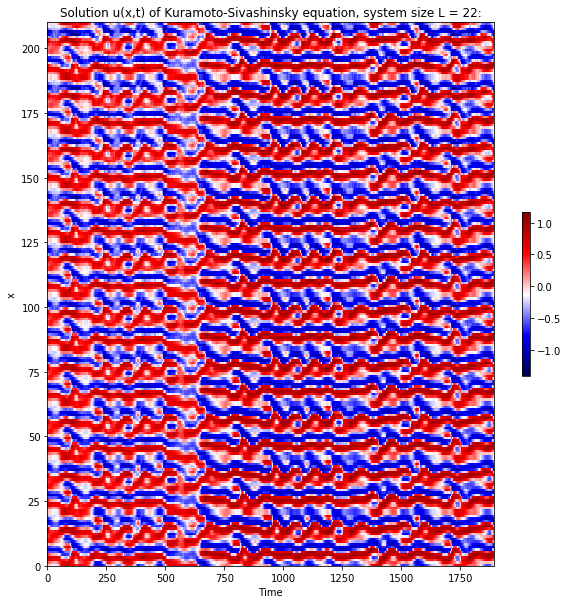

In [6]:
plt.figure(figsize=(10,10))
plt.title('Solution u(x,t) of Kuramoto-Sivashinsky equation, system size L = 22:')
plt.ylabel('x')
plt.xlabel('Time')
im=plt.pcolormesh(pred_output.T[:,:-roll_num], cmap='seismic')
plt.colorbar(im, shrink=0.3)
# plt.axes().set_aspect(.5) # 4*spatial_points/sequence_length
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

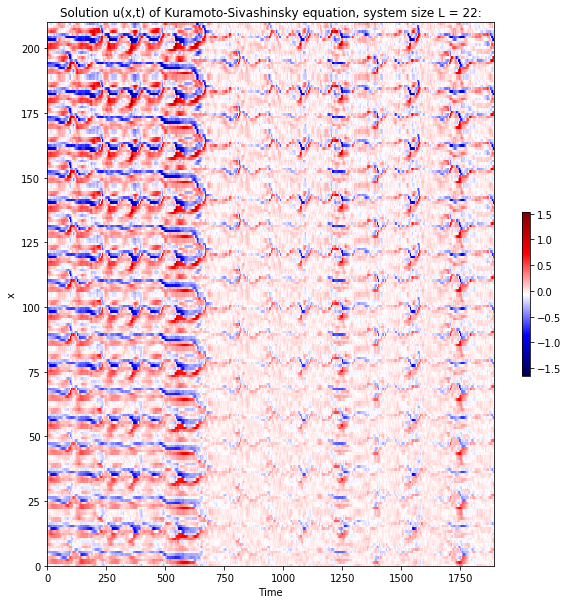

In [7]:
plt.figure(figsize=(10,10))
plt.title('Solution u(x,t) of Kuramoto-Sivashinsky equation, system size L = 22:')
plt.ylabel('x')
plt.xlabel('Time')
im=plt.pcolormesh((y_target.T - pred_output.T)[:,:-roll_num], cmap='seismic')
plt.colorbar(im, shrink=0.3)
# plt.axes().set_aspect(.5) # 4*spatial_points/sequence_length
plt.show